In [9]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Define the stock symbol and date range
stock_symbol = 'AAPL'
start_date = '2020-01-01'
end_date = '2023-07-16'

# Fetch historical stock price data from Yahoo Finance
stock_data = yf.download(stock_symbol, start=start_date, end=end_date)

# Display the first few rows of the stock data
print(stock_data.head())


[*********************100%%**********************]  1 of 1 completed

                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2020-01-02  74.059998  75.150002  73.797501  75.087502  72.960457  135480400
2020-01-03  74.287498  75.144997  74.125000  74.357498  72.251144  146322800
2020-01-06  73.447502  74.989998  73.187500  74.949997  72.826843  118387200
2020-01-07  74.959999  75.224998  74.370003  74.597504  72.484337  108872000
2020-01-08  74.290001  76.110001  74.290001  75.797501  73.650345  132079200


In [21]:
# Handle missing values using forward fill and backward fill
stock_data.ffill(inplace=True)  # Forward fill
stock_data.bfill(inplace=True)  # Backward fill

# Remove anomalies (e.g., outliers) and ensure no NaN or infinite values
stock_data = stock_data.dropna()  # Drop rows with any NaN values
stock_data = stock_data.replace([np.inf, -np.inf], np.nan).dropna()  # Drop rows with infinite values

# Ensure all values are finite
assert np.isfinite(stock_data).all().all(), "Data contains non-finite values"

# Display the cleaned and processed data
print(stock_data.head())




                 Open       High        Low      Close  Adj Close  \
Date                                                                
2020-01-02  74.059998  75.150002  73.797501  75.087502  72.960457   
2020-01-03  74.287498  75.144997  74.125000  74.357498  72.251144   
2020-01-06  73.447502  74.989998  73.187500  74.949997  72.826843   
2020-01-07  74.959999  75.224998  74.370003  74.597504  72.484337   
2020-01-08  74.290001  76.110001  74.290001  75.797501  73.650345   

                 Volume  Day  Month  Weekday  
Date                                          
2020-01-02  135480400.0  2.0    1.0      3.0  
2020-01-03  146322800.0  3.0    1.0      4.0  
2020-01-06  118387200.0  6.0    1.0      0.0  
2020-01-07  108872000.0  7.0    1.0      1.0  
2020-01-08  132079200.0  8.0    1.0      2.0  


In [22]:
# Ensure the date index has a frequency
stock_data = stock_data.asfreq('B')

# Create time-based features using .loc to avoid SettingWithCopyWarning
stock_data.loc[:, 'Day'] = stock_data.index.day
stock_data.loc[:, 'Month'] = stock_data.index.month
stock_data.loc[:, 'Weekday'] = stock_data.index.weekday

# Display the data with new features
print(stock_data.head())


                 Open       High        Low      Close  Adj Close  \
Date                                                                
2020-01-02  74.059998  75.150002  73.797501  75.087502  72.960457   
2020-01-03  74.287498  75.144997  74.125000  74.357498  72.251144   
2020-01-06  73.447502  74.989998  73.187500  74.949997  72.826843   
2020-01-07  74.959999  75.224998  74.370003  74.597504  72.484337   
2020-01-08  74.290001  76.110001  74.290001  75.797501  73.650345   

                 Volume  Day  Month  Weekday  
Date                                          
2020-01-02  135480400.0  2.0    1.0      3.0  
2020-01-03  146322800.0  3.0    1.0      4.0  
2020-01-06  118387200.0  6.0    1.0      0.0  
2020-01-07  108872000.0  7.0    1.0      1.0  
2020-01-08  132079200.0  8.0    1.0      2.0  


Results of Dickey-Fuller Test:
Test Statistic                  -1.418435
p-value                          0.573407
#Lags Used                       0.000000
Number of Observations Used    920.000000
Critical Value (1%)             -3.437478
Critical Value (5%)             -2.864687
Critical Value (10%)            -2.568445
dtype: float64
Series is not stationary. Performing differencing (d=1)...


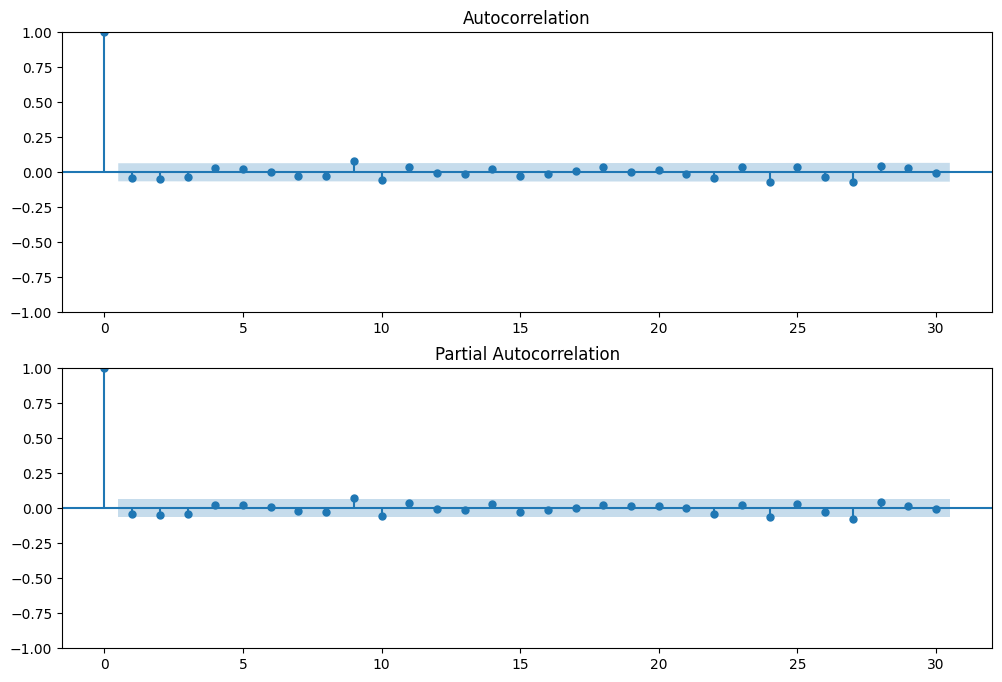

Selected p=1, q=1


C:\Users\ASUS\AppData\Local\Temp\ipykernel_25492\4143515581.py:61: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  arima_forecast = arima_result.forecast(steps=forecast_steps)[0]


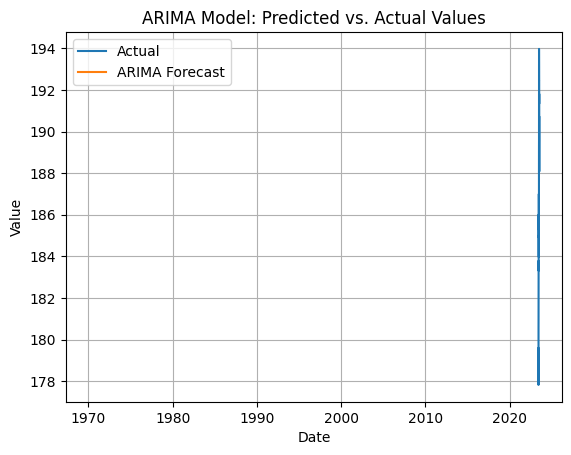

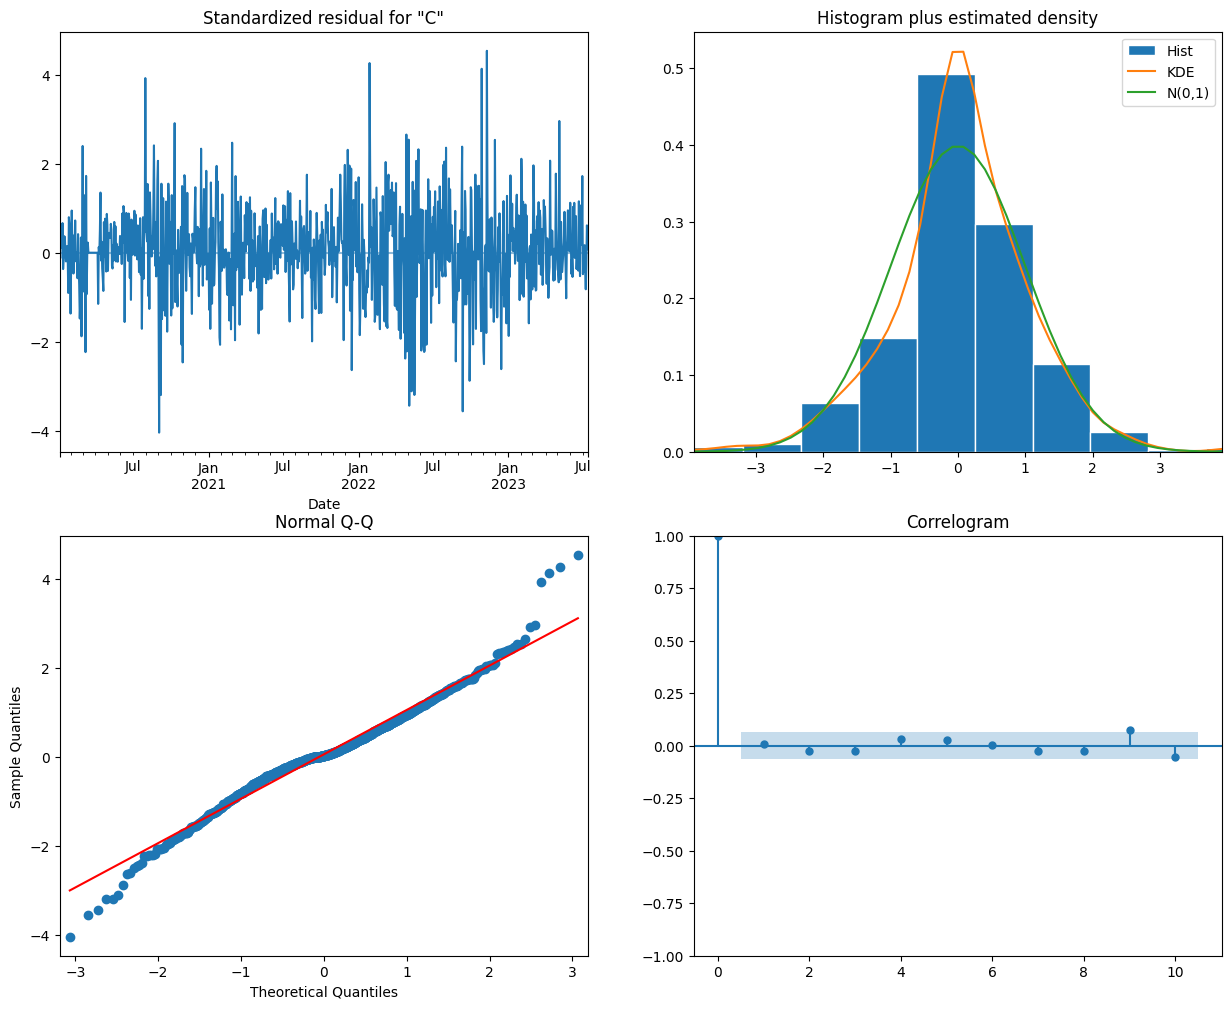

In [87]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

# Function to check stationarity and perform differencing if needed
def test_stationarity(timeseries):
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    if dftest[1] > 0.05:
        print("Series is not stationary. Performing differencing (d=1)...")
        timeseries_diff = timeseries.diff().dropna()
        return timeseries_diff
    else:
        print("Series is stationary.")
        return timeseries

# Function to determine p and q values from ACF and PACF plots automatically
def determine_p_q(timeseries):
    # Plot ACF and PACF
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    plot_acf(timeseries, lags=30, ax=ax1)
    plot_pacf(timeseries, lags=30, ax=ax2)
    plt.show()
    
    # Determine p value based on PACF where it crosses the significance threshold
    pacf_values = pacf(timeseries, nlags=30)
    confint = 1.96 / np.sqrt(len(timeseries))  # 95% confidence interval
    p = next(i for i, val in enumerate(pacf_values) if abs(val) <= confint)
    
    # Determine q value based on ACF where it crosses the significance threshold
    acf_values = acf(timeseries, nlags=30)
    confint = 1.96 / np.sqrt(len(timeseries))  # 95% confidence interval
    q = next(i for i, val in enumerate(acf_values) if abs(val) <= confint)
    
    return p, q

# Example usage:
# Assuming stock_data is your DataFrame with 'Close' prices

# Test stationarity and perform differencing if necessary
stationary_data = test_stationarity(stock_data['Close'])

# Determine p and q values automatically from ACF and PACF plots
p, q = determine_p_q(stationary_data)
print(f"Selected p={p}, q={q}")

# Fit ARIMA model
arima_model = ARIMA(stock_data['Close'], order=(p, 1, q))
arima_result = arima_model.fit()

# Forecast future values
forecast_steps = 30
arima_forecast = arima_result.forecast(steps=forecast_steps)[0]

# Plotting actual values
plt.plot(stock_data['Close'][-forecast_steps:], label='Actual')

# Plotting predicted values
plt.plot(arima_forecast, label='ARIMA Forecast')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('ARIMA Model: Predicted vs. Actual Values')
plt.legend()
plt.grid(True)
plt.show()

# Display model diagnostics
arima_result.plot_diagnostics(figsize=(15, 12))
plt.show()



Iteration:      1,   Func. Count:      6,   Neg. LLF: 31670.60711753829
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5352.829007261161
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4281.672667074241
Iteration:      4,   Func. Count:     25,   Neg. LLF: 4058.3769670166357
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4060.552388208092
Iteration:      6,   Func. Count:     37,   Neg. LLF: 4007.1074796955927
Iteration:      7,   Func. Count:     43,   Neg. LLF: 4005.769184501379
Iteration:      8,   Func. Count:     49,   Neg. LLF: 4000.4461932430477
Iteration:      9,   Func. Count:     55,   Neg. LLF: 3873.385218882541
Iteration:     10,   Func. Count:     60,   Neg. LLF: 4124.306969621081
Iteration:     11,   Func. Count:     66,   Neg. LLF: 3872.3276238743556
Iteration:     12,   Func. Count:     71,   Neg. LLF: 3872.019533300935
Iteration:     13,   Func. Count:     76,   Neg. LLF: 3871.8267301560627
Iteration:     14,   Func. Count:     81,   Neg. LLF: 3871.

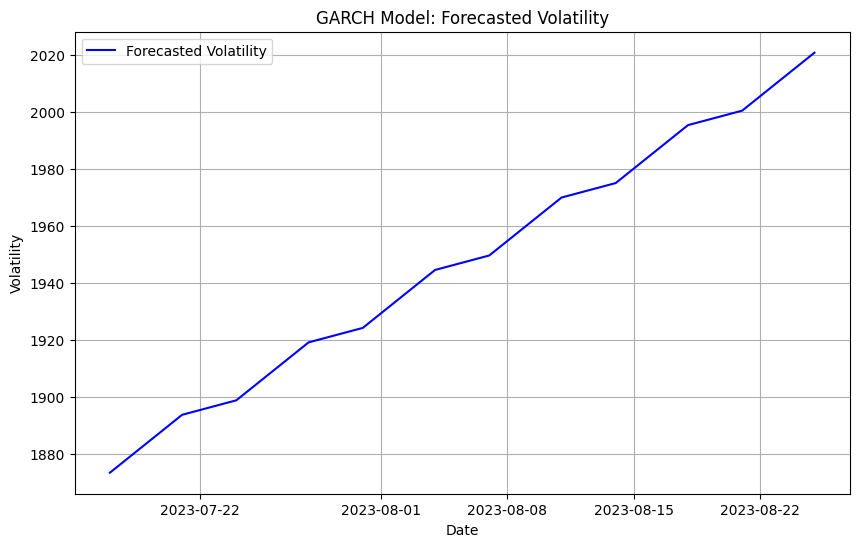

In [88]:
from arch import arch_model
import matplotlib.pyplot as plt

# Fit GARCH model
garch_model = arch_model(stock_data['Close'], vol='Garch', p=1, q=1)
garch_result = garch_model.fit()

# Forecast future volatility
forecast_horizon = 30
garch_forecast = garch_result.forecast(horizon=forecast_horizon)

# Extracting forecasted volatility values
forecasted_volatility = garch_forecast.variance.values[-1]

# Creating dates for forecasted volatility
forecast_dates = pd.date_range(start=stock_data.index[-1], periods=forecast_horizon + 1, freq='B')[1:]

# Plotting forecasted volatility
plt.figure(figsize=(10, 6))
plt.plot(forecast_dates, forecasted_volatility, label='Forecasted Volatility', color='blue')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.title('GARCH Model: Forecasted Volatility')
plt.legend()
plt.grid(True)
plt.show()


In [65]:
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Prepare data for LSTM model
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(stock_data['Close'].values.reshape(-1, 1))

train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return tf.convert_to_tensor(X, dtype=tf.float32), tf.convert_to_tensor(y, dtype=tf.float32)

time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape data for LSTM model (samples, time steps, features)
X_train = tf.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = tf.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Build LSTM model using Functional API
inputs = tf.keras.layers.Input(shape=(time_step, 1))
lstm_layer1 = tf.keras.layers.LSTM(50, return_sequences=True)(inputs)
lstm_layer2 = tf.keras.layers.LSTM(50, return_sequences=False)(lstm_layer1)
dense_layer1 = tf.keras.layers.Dense(25)(lstm_layer2)
outputs = tf.keras.layers.Dense(1)(dense_layer1)

lstm_model = tf.keras.Model(inputs=inputs, outputs=outputs)

lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Fit LSTM model
lstm_model.fit(X_train, y_train, batch_size=1, epochs=1)

# Predict on test data and inverse transform predictions
lstm_predictions = lstm_model.predict(X_test)
lstm_predictions = scaler.inverse_transform(lstm_predictions)

print("LSTM Predictions:")
print(lstm_predictions)


676/676 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.0181
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
LSTM Predictions:
[[136.80656]
 [137.8298 ]
 [139.02248]
 [140.16707]
 [141.369  ]
 [142.66505]
 [143.66452]
 [144.52217]
 [145.3099 ]
 [146.43408]
 [147.95824]
 [149.35742]
 [150.83234]
 [151.98682]
 [152.77562]
 [153.28958]
 [153.82938]
 [154.26491]
 [154.78488]
 [155.16133]
 [155.32875]
 [155.35927]
 [154.953  ]
 [154.37088]
 [153.76285]
 [152.95451]
 [152.20587]
 [151.50256]
 [150.71039]
 [149.99075]
 [149.80003]
 [150.15948]
 [150.6319 ]
 [151.2629 ]
 [151.74475]
 [151.93478]
 [152.10852]
 [152.42468]
 [152.82436]
 [153.48537]
 [154.16629]
 [155.0171 ]
 [156.05208]
 [156.9823 ]
 [157.87752]
 [158.78477]
 [159.44539]
 [159.85706]
 [160.35335]
 [160.9754 ]
 [161.83371]
 [162.8615 ]
 [163.8548 ]
 [164.58545]
 [165.18556]
 [165.64636]
 [165.74913]
 [165.53133]
 [165.07773]
 [164.99553]
 [165.07492]
 [165.25273]
 [165.58669]
 [166.0838 ]
 [166.54736]
 [166.8172 ]
 [166.98509]
 [166.93517]
 [1

In [69]:
import numpy as np

# Assuming lstm_predictions is longer than actual_values, truncate lstm_predictions
lstm_predictions = lstm_predictions[:len(actual_values)]

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_values, lstm_predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calculate MAE
mae = mean_absolute_error(actual_values, lstm_predictions)
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Ensure both inputs are 1-dimensional arrays
actual_values = np.squeeze(actual_values)
lstm_predictions = np.squeeze(lstm_predictions)

mape = mean_absolute_percentage_error(actual_values, lstm_predictions)
print(f"Mean Absolute Percentage Error (MAPE): {mape}")



Root Mean Squared Error (RMSE): 37.66380014006551
Mean Absolute Error (MAE): 37.56966705322266
Mean Absolute Percentage Error (MAPE): 20.147706279240534


In [45]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np


In [46]:
# Prepare data for Linear Regression
X = stock_data[['Day', 'Month', 'Weekday']]
y = stock_data['Close']

# Split into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]



In [47]:
# Train Linear Regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)





LinearRegression()

In [50]:
# Predict on the test set
linear_predictions = linear_model.predict(X_test)

# Calculate RMSE using mean_squared_error with squared=False
rmse = np.sqrt(mean_squared_error(y_test, linear_predictions))
print(f"Root Mean Squared Error (RMSE) of Linear Regression model: {rmse}")



Root Mean Squared Error (RMSE) of Linear Regression model: 35.7725237314865


In [57]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


In [58]:
# Create binary target variable: Price_Up (1 if next day's Close price is higher, else 0)
stock_data['Price_Up'] = (stock_data['Close'].shift(-1) > stock_data['Close']).astype(int)

# Prepare data for Logistic Regression
X = stock_data[['Day', 'Month', 'Weekday']]
y = stock_data['Price_Up']

# Split into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [59]:
# Train Logistic Regression model
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)


LogisticRegression()

In [60]:
# Predict on the test set
logistic_predictions = logistic_model.predict(X_test)

# Calculate accuracy
logistic_accuracy = accuracy_score(y_test, logistic_predictions)
print(f"Logistic Regression Accuracy: {logistic_accuracy}")


Logistic Regression Accuracy: 0.41081081081081083


In [53]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np


In [54]:
# Prepare data for Random Forest
X = stock_data[['Day', 'Month', 'Weekday']]
y = stock_data['Close']

# Split into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [55]:
# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(X_train, y_train)


RandomForestRegressor()

In [56]:
# Predict on the test set
rf_predictions = rf_model.predict(X_test)

# Calculate RMSE using mean_squared_error with squared=False
rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))
print(f"Root Mean Squared Error (RMSE) of Random Forest model: {rmse}")


Root Mean Squared Error (RMSE) of Random Forest model: 36.441368003012
